Loaded dataset shape: (11162, 17)
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  
Using detected target column: deposit
Target distribution:
 depos

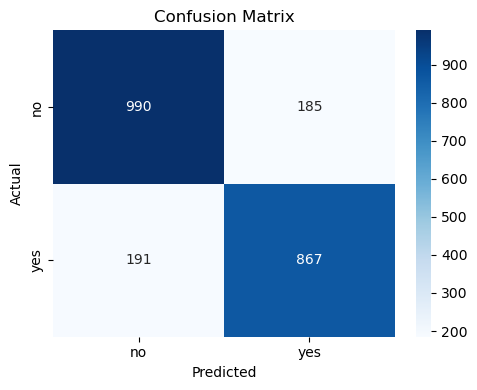

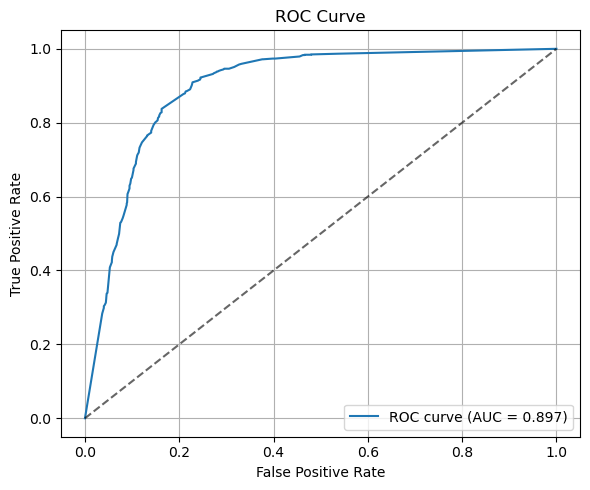

ROC AUC: 0.897051441901621


C:\Users\OWAIS\AppData\Local\Temp\ipykernel_24632\3663456265.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette="viridis")


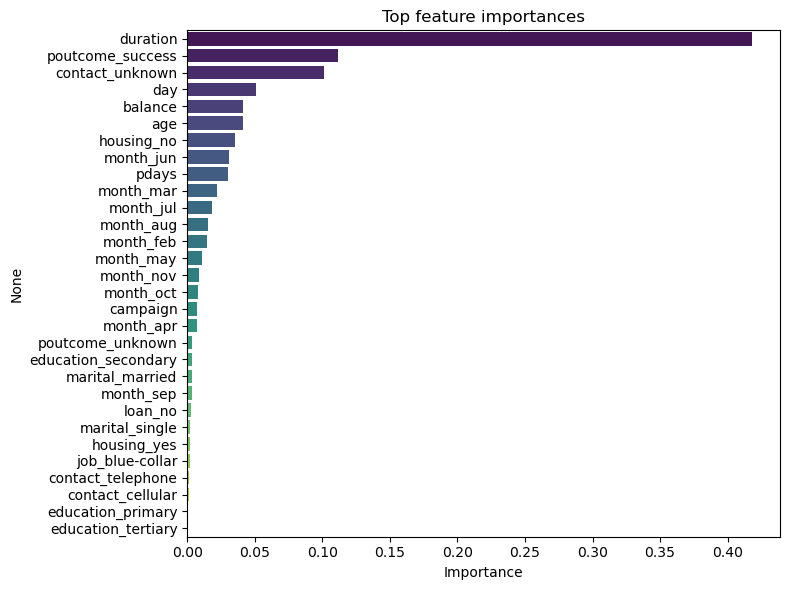

Top features:
 duration            0.417853
poutcome_success    0.111545
contact_unknown     0.101026
day                 0.050552
balance             0.041093
age                 0.041077
housing_no          0.035316
month_jun           0.030959
pdays               0.030274
month_mar           0.022265
month_jul           0.018588
month_aug           0.015567
month_feb           0.014759
month_may           0.010765
month_nov           0.008678
dtype: float64


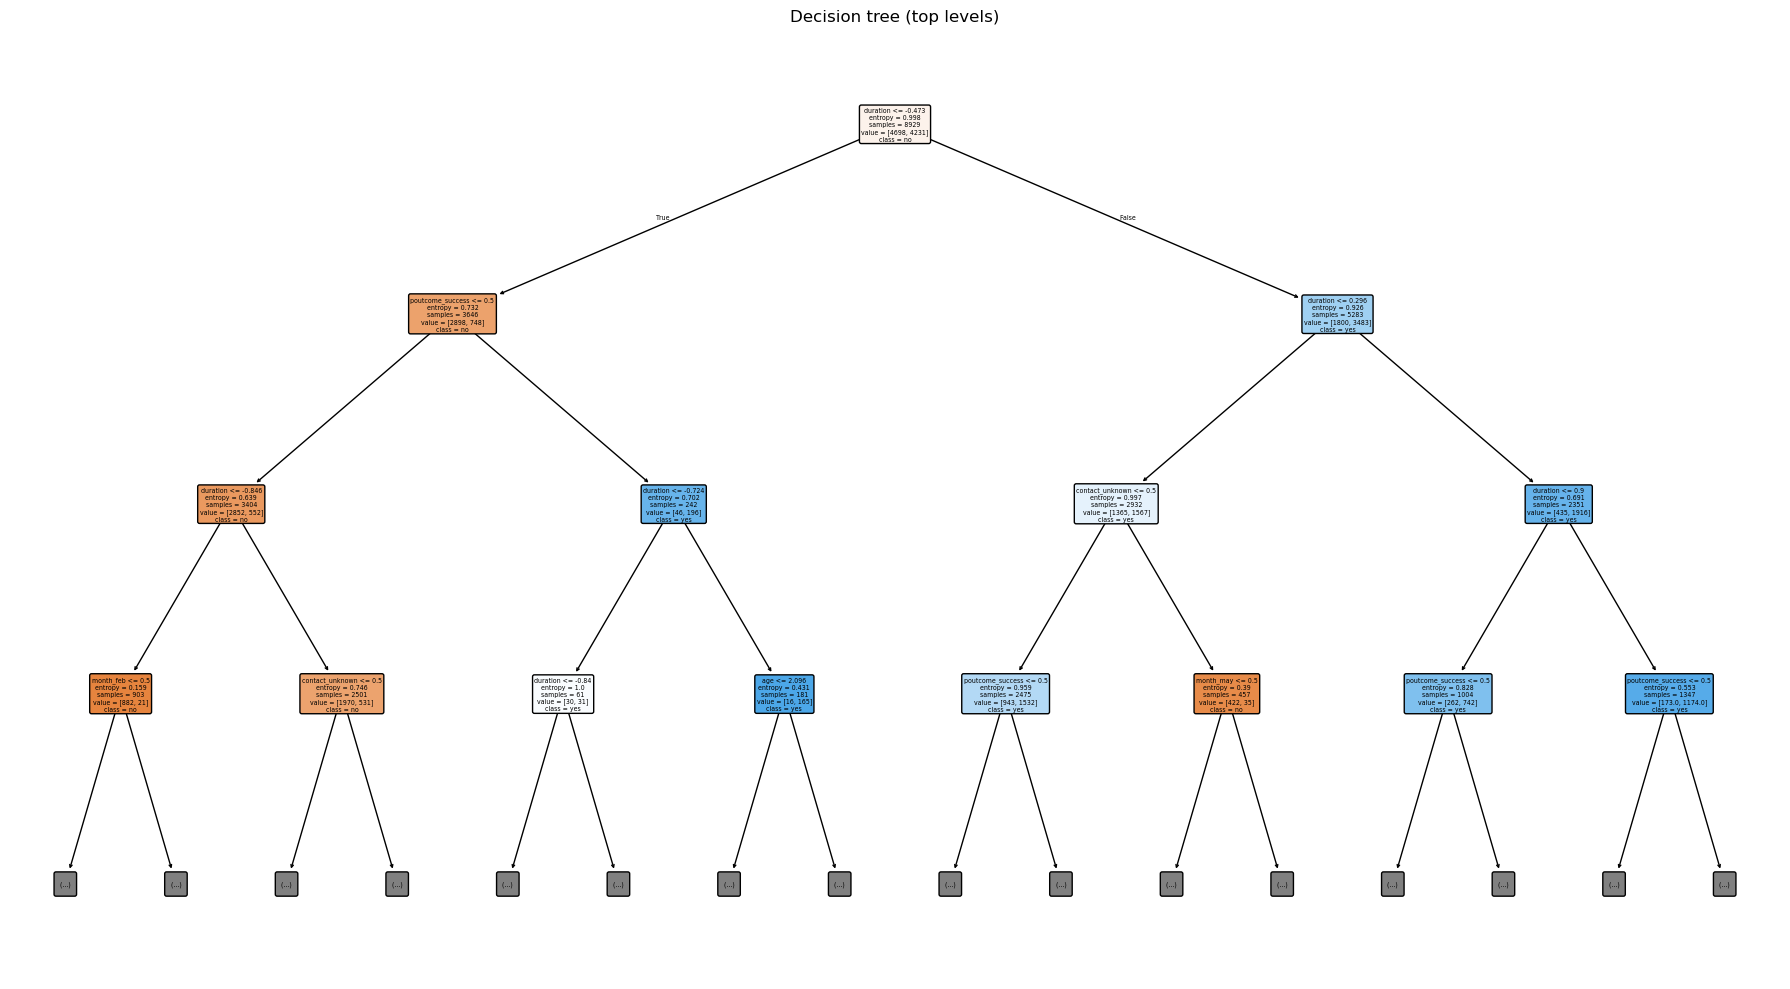

Saved model to best_dt_pipeline.joblib


In [5]:
# bank_decision_tree_fixed_complete.py
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# ---------------------------
# Configuration
# ---------------------------
# Update DATA_PATH to point to your CSV file location
DATA_PATH = Path(r"D:\prodigy infotech internship tasks\bank.csv")
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ---------------------------
# Load dataset
# ---------------------------
if not DATA_PATH.exists():
    print("Current working directory:", Path.cwd())
    print("Looking for dataset at:", DATA_PATH)
    try:
        print("Files in dataset parent dir (sample):", list(DATA_PATH.parent.iterdir())[:20])
    except Exception:
        pass
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Download from Kaggle and save as {DATA_PATH}.")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
print(df.head())

# ---------------------------
# Basic inspection and cleanup
# ---------------------------
TARGET_COL = "y"
if TARGET_COL not in df.columns:
    possible = [c for c in df.columns if c.lower() in ("target", "subscribed", "deposit", "y")]
    if len(possible) == 0:
        raise ValueError("Target column not found. Ensure dataset contains target label 'y' or similar.")
    TARGET_COL = possible[0]
    print("Using detected target column:", TARGET_COL)

df = df.dropna(subset=[TARGET_COL])
print("Target distribution:\n", df[TARGET_COL].value_counts(normalize=True))

# ---------------------------
# Feature selection
# ---------------------------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].map(lambda v: 1 if str(v).strip().lower() in ("yes", "1", "true") else 0)

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# ---------------------------
# Preprocessing pipeline
# ---------------------------
# Make OneHotEncoder kwargs portable across sklearn versions
sk_version = tuple(map(int, sklearn.__version__.split(".")[:2]))
ohe_kwargs = {"handle_unknown": "ignore"}
if sk_version >= (1, 2):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

transformers = []
if len(num_cols) > 0:
    transformers.append(("num", StandardScaler(), num_cols))
if len(cat_cols) > 0:
    transformers.append(("cat", OneHotEncoder(**ohe_kwargs), cat_cols))

if len(transformers) == 0:
    raise ValueError("No numeric or categorical features found in X.")

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

# ---------------------------
# Model pipeline and hyperparameter tuning
# ---------------------------
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", dt)
])

param_grid = {
    "clf__max_depth": [3, 5, 8, 12, None],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__criterion": ["gini", "entropy"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1
)

# ---------------------------
# Train-test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---------------------------
# Fit
# ---------------------------
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

best_model = grid.best_estimator_

# ---------------------------
# Evaluation
# ---------------------------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nTest metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["no", "yes"], yticklabels=["no", "yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC AUC if probabilities available
if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("ROC AUC:", auc)

# ---------------------------
# Feature importances (fixed)
# ---------------------------
preproc = best_model.named_steps["preproc"]
ohe_feature_names = []

# numeric feature names in order
out_num_cols = num_cols.copy() if len(num_cols) > 0 else []

# Access named_transformers_ safely (set after fitting)
named = getattr(preproc, "named_transformers_", None)
if named is None:
    # fallback: build mapping from transformers_ tuples (name, transformer, cols)
    named = {name: trans for name, trans, cols in getattr(preproc, "transformers_", [])}

# Extract categorical transformer (if present)
encoder = None
if "cat" in named:
    cat_transformer = named["cat"]
    # if the transformer is a Pipeline, take the last step
    if hasattr(cat_transformer, "named_steps"):
        last_step_name = list(cat_transformer.named_steps.keys())[-1]
        encoder = cat_transformer.named_steps[last_step_name]
    else:
        encoder = cat_transformer

# Build OHE feature names
if encoder is not None:
    if hasattr(encoder, "get_feature_names_out"):
        try:
            ohe_feature_names = list(encoder.get_feature_names_out(cat_cols))
        except Exception:
            if hasattr(encoder, "categories_"):
                names = []
                for c, cats in zip(cat_cols, encoder.categories_):
                    names.extend([f"{c}_{v}" for v in cats])
                ohe_feature_names = names
            else:
                ohe_feature_names = []
    else:
        if hasattr(encoder, "categories_"):
            names = []
            for c, cats in zip(cat_cols, encoder.categories_):
                names.extend([f"{c}_{v}" for v in cats])
            ohe_feature_names = names
        else:
            ohe_feature_names = []

feature_names = out_num_cols + ohe_feature_names

clf = best_model.named_steps["clf"]
if hasattr(clf, "feature_importances_") and len(feature_names) == len(clf.feature_importances_):
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=fi.values, y=fi.index, palette="viridis")
    plt.title("Top feature importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
    print("Top features:\n", fi.head(15))
else:
    print("Could not map feature importances to names.")
    print("len(feature_names) =", len(feature_names))
    print("len(feature_importances_) =", getattr(clf, "feature_importances_", "N/A"))

# ---------------------------
# Print a small textual tree (for small depth)
# ---------------------------
if hasattr(clf, "get_depth") and clf.get_depth() <= 6:
    try:
        tree_text = export_text(clf, feature_names=feature_names, max_depth=6)
        print("\nDecision tree structure:\n")
        print(tree_text)
    except Exception:
        print("Could not print textual tree (feature name mismatch).")

# ---------------------------
# Plot the tree (visual)
# ---------------------------
plt.figure(figsize=(18, 10))
try:
    plot_tree(clf, feature_names=feature_names, class_names=["no", "yes"], filled=True, rounded=True, max_depth=3)
    plt.title("Decision tree (top levels)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot tree failed:", e)
    print("You can export with export_graphviz if graphviz is installed.")

# ---------------------------
# Save the trained model (optional)
# ---------------------------
try:
    import joblib
    joblib.dump(best_model, "best_dt_pipeline.joblib")
    print("Saved model to best_dt_pipeline.joblib")
except Exception:
    print("joblib not installed or save failed; skipping model save.")